In [ ]:
# import the necessary packages
import numpy as np 
import helper_functions

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (20,20)
global do_debug

# --------- Set to true if want to see the first 20 LBP images with features matrix
do_debug = False
#do_debug = True

class features_class:
    def __init__(self,X,y,img_names):
        self.X = X
        self.y = y
        self.img_names=img_names
        self.base_path=""
        self.set_start_i=[] # indices in the features list for each dataset
        self.set_stop_i=[]
        self.md5="" #for future use -> check if files have changed
                
class image_preprocess:
    #Constructor
    """
    Inputs:
        
        method: "pass " -> no transformation is applied
                "contours" -> mask input image with contours.
                "cmask" -> generate mask then apply to features matrix
                
        thickness : Only used when method is "contours" or "cmask"
    
    Functions:
        process (image_path, path_to_save)
            inputs: image_path -> path for image to process. NOTE: it needs to have "work" in the path
            output: image_out -> output image. This will also be saved to disk if it does not exist
    """
    def __init__(self, method="pass", params=[]):
        self.method   = method
        self.params   = params
        self.post_process_mask = None
        if len(params)>0:
            self.thickness = params['thick'] # first param is thickness
        if len(params)>1:
            self.k = params['k'] # second param is gain
               
    def process (self, image_path):      
        binary_threshold = 40
        import cv2
        import numpy as np
        import os

        if self.method == "pass":
            # [ Read image from path and return it unchanged]
            image =  cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            return image
        elif self.method == "contours":
            # check if file is already generated
            if not "work" in image_path:
                print "ERROR: make sure the images have 'work' in the path directory"
                return None
            out_filename = image_path.replace("work","work_contours_T-" + str(self.thickness))
            if os.path.isfile(out_filename):
                # If file exists, simply load it
                my_out_img=  cv2.imread(out_filename, cv2.IMREAD_GRAYSCALE)
                return my_out_img
            else:
                # File does not exist, generate it
                orig_img   = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                elem_open  = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5)) # create a 5x5 processing filter
                                                                             # for opening 
                elem_close = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
                img_open   = cv2.morphologyEx(orig_img,cv2.MORPH_OPEN ,elem_open ) # Image with open morphological op

                img_filt        = cv2.morphologyEx(img_open,cv2.MORPH_CLOSE,elem_close) # Closing morphological op
                # Threshold to binary
                ret, im_bin     = cv2.threshold(img_filt,binary_threshold,1,cv2.THRESH_BINARY)
                # Create contours using the binary image
                if "4.0.0" in cv2.__version__:
                    my_contours, hierarchy = cv2.findContours(im_bin.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
                else:
                    im2, my_contours, hierarchy = cv2.findContours(im_bin.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
                # Write a simple contours mask
                #print 'self.thickness = ', self.thickness
                mask_ext = cv2.drawContours(im_bin.copy(),my_contours,-1,255,self.thickness)
                mask = cv2.drawContours(mask_ext.copy(),my_contours,-1,100,2)
                my_masked_orig = np.where((mask_ext==255),orig_img,0)

                # Check if the out path is differnt from source ... Otherwise something has gone wrong
                if out_filename != image_path:
                    print 'Creating: ', out_filename
                    base_dir = os.path.split(out_filename)[0]
                    if not os.path.isdir(base_dir):
                        os.makedirs(base_dir) # create dir if it doesn't exist
                    cv2.imwrite(out_filename, my_masked_orig)
                # [ Return the image with masked contours]
                return my_masked_orig
            
        elif self.method == "cmask" or self.method== "comb":
            # -----------
            #  This method reads an image, generates a contours mask and
            #      - returns the original image (unchanged)
            #      - stores the contours mask as a local variable
            # -----------
            # check if file is already generated
            if not "work" in image_path:
                print "ERROR: make sure the images have 'work' in the path directory"
                return None
            out_filename = image_path.replace("work","work_cmask_T-" + str(self.thickness))
            if os.path.isfile(out_filename):
                # If file exists, simply load it
                self.post_process_mask =  cv2.imread(out_filename, cv2.IMREAD_GRAYSCALE)
                orig_img   = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                return orig_img
            else:
                # File does not exist, generate it
                orig_img   = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if orig_img is None:
                    raise Exception(" Could not load image '%s'" %(image_path))
                elem_open  = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5)) # create a 5x5 processing filter
                                                                             # for opening 
                elem_close = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
                img_open   = cv2.morphologyEx(orig_img.copy(),cv2.MORPH_OPEN ,elem_open ) # Image with open morphological op

                img_filt        = cv2.morphologyEx(img_open,cv2.MORPH_CLOSE,elem_close) # Closing morphological op
                # Threshold to binary
                ret, im_bin     = cv2.threshold(img_filt,binary_threshold,1,cv2.THRESH_BINARY)
                # Create contours using the binary image
                if "4.0.0" in cv2.__version__:
                    my_contours, hierarchy = cv2.findContours(im_bin.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
                else:
                    im2, my_contours, hierarchy = cv2.findContours(im_bin.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
                # Write a simple contours mask
                #print 'self.thickness = ', self.thickness
                mask = cv2.drawContours(im_bin.copy(),my_contours,-1,255,self.thickness)

                # Note:    for the combined mask (or post_process_mask)
                #   mask value of 255 -> contour of given thickness
                #   mask value of   1 -> segmented pixel found to be "green" as per original image
                #   mask value of   0 -> segmented pixel not green
                
                # Mask original image:  - Value of 0 where there is no contour
                #                       - Pixel value from orig_img if it's on the masked contour
                
                # Check if the out path is differnt from source ... Otherwise something has gone wrong
                if out_filename != image_path:
                    print 'Creating: ', out_filename
                    base_dir = os.path.split(out_filename)[0]
                    if not os.path.isdir(base_dir):
                        os.makedirs(base_dir) # create dir if it doesn't exist
                    cv2.imwrite(out_filename, mask)
                # [ Return the original mage and set the post process mask]
                self.post_process_mask = mask
                return orig_img

class plant_feature_extraction:
    def __init__(self,method,params):
        # Given method can also a features filter argument. We don't want to put the filter
        # arguments in our self.params vector as we want the same name file for the extracted
        # features. This way, we'll have the same features files for all fitler methods and
        # save quite a bit of computation time.
        
        self.method_and_filter = method
        self.method = method.split('-filtered')[0] # first split is actual extractor method
                
        if '-filtered' in self.method_and_filter:
            self.features_filter = 'filtered-' + self.method_and_filter.split('-filtered')[1]# second split is fitlter arguments
        else:
            self.features_filter = 'none'
        self.params = params
        # ----------------------------
        # Internal variables which can change after class instantiation
        self.file_base_name = None  # lbp_rui_r1_n8_r2_n16_r3_n24
        self.features_file_name = None  # this will be updated when calling initialise()
                                        # according to the latest operators      
        self.n_bins         = None
        self.e_params       = None
        self.is_initialised = None
        
        self.work_dir       = None
        self.dataset_lists  = []        # This will hold the dataset filenames (i.e. dataset_list_1..5) 
        
    def initialise(self, preprocessor ,work_dir):
        import helper_functions as hlp
        from natsort import natsorted
        
        # Define our dataset training/testing names
        self.file_base_name      = 'lbp-' + self.method
        # Calculate internal variables according to given methods
        pp_base_name='PP-' + preprocessor.method
        
        for my_operator in  self.params:
            self.file_base_name += '-r%d-n%d' %( my_operator[0],my_operator[1])        

        for key in preprocessor.params:
            pp_base_name += '-' + key + '-' + str(preprocessor.params[key]) # String containing all our params and values
                                                                            # so that we don't need to regenerate
        self.features_file_name  = 'features_' +'FE-'+ self.file_base_name + '_' + pp_base_name + '.pickle'
        self.file_base_name +=  pp_base_name         
        self.work_dir        = work_dir
        self.out_dir         = work_dir.replace('work','out')    
        self.nprocessed = 0;
        
        # Update dataset lists
        dataset_lists = hlp.list_files(self.work_dir,name_prefix="dataset_list" ,file_ext='txt')
        self.dataset_lists = natsorted(dataset_lists)# just keep files in alphanumnerical order
        if do_debug:
            print ' DEBUG: Dataset lists are:', self.dataset_lists
        if len(self.dataset_lists) == 0:
            raise Exception(" Dataset is empty! No valid files found in '%s'" %(self.work_dir))
        self.is_initialised = 1
        
    def get_features_histogram (self, image, pp):
        import numpy as np
        from skimage import feature
        
        bins_combined = []
        method = self.method.replace('-filtered','') # we don't need the extra -filtered indication here
        self.nprocessed+=1;
        if method == 'rui':
            for r_n_param in self.params:
                r = r_n_param[0]
                n = r_n_param[1]
                fill_value = 255 # |NOTE THIS APPEARS in the LBP image when masking but we'll ignore as n+2 <255
                my_lbp_matrix  = feature.local_binary_pattern(image, n, r, method="uniform")
                if pp.post_process_mask is not None:
                    masked_lbp_matrix  = np.where((pp.post_process_mask==255),my_lbp_matrix,fill_value)
                else:
                    masked_lbp_matrix = my_lbp_matrix
                # Just a simple debug window into what's going on. MAKE sure you disable for the long run
                if do_debug and self.nprocessed < 10:
                    plt.subplot(1,2,1)
                    plt.imshow(image)
                    plt.title('Orignal')
                    plt.subplot(1,2,2)
                    plt.imshow(masked_lbp_matrix)
                    if pp.post_process_mask is None:
                        plt.title('LBP matrix')
                    else:
                        plt.title('Masked LBP matrix')
                    plt.show()
                    self.debug_last_mask= pp.post_process_mask
                    self.debug_last_lbp_matrix = my_lbp_matrix
                    self.debug_last_masked_lbp_matrix = masked_lbp_matrix
                    self.debug_last_image = image
                
                my_bins, my_edges = np.histogram(masked_lbp_matrix.ravel(),bins=np.arange(0, n+3), range=(0,n+2))
                if pp.method == "comb":
                    bins_from_full_img, my_edges = np.histogram(my_lbp_matrix.ravel(),bins=np.arange(0, n+3), range=(0,n+2))
                    my_bins = my_bins + (bins_from_full_img * pp.k).astype('int64');
                bins_combined = np.concatenate( (bins_combined,my_bins) ,axis=0)
                #print 'DEBUG: %s , n= %d, r = %d ; n_bins = %d' %(str(r_n_param),n,r,len(bins_combined) )                
        self.n_bins = len(bins_combined)
        return bins_combined
    
    def apply_features_filter(self, given_features):
        if self.features_filter is not None:
            #for i in range(len(my_features.X)): # apply some scaling?
            #    temp = my_features.X[i]
            #    X[i] *= float(temp[8])/(228*228);     
            X = np.delete(given_features.X,[8,26,52],1)
            given_features.X = X
            return given_features

    def check_features_file(self,pp, out_filename):
        """
            This function generates the comb method test/train features file from 
            existing pass and cmask pickle files (so that we don't have to re-compute for a change of
            k parameter). The formula used is: 
            comb_features = cmask_features + k* pass_features
        """
        import os
        import pickle
        # check if file already exists
        if os.path.isfile(out_filename):
            return
        if pp.method == "comb":
            # this method takes 2 files of generated features and combines them
            # so check if these 2 files exist
            base_name = out_filename.split('comb-')[0]
            pass_features_filename = base_name + "pass.pickle"
            cmask_features_filename = base_name + "cmask-thick-"+str(pp.thickness) + ".pickle"
            if os.path.isfile(pass_features_filename) and os.path.isfile(cmask_features_filename):
                print ' Generating %s file from existing cmask and pass feature files' %(out_filename)
                with open (pass_features_filename,'rb') as f:
                    my_features_pass = pickle.load(f)
                        
                    print "From pass file: Loaded %d images x %d features " %(len(my_features_pass.X), len(my_features_pass.X[1]))
                with open (cmask_features_filename,'rb') as f:
                    my_features_cmask = pickle.load(f)
                    print "From cmask file: Loaded %d images x %d features " %(len(my_features_cmask.X), len(my_features_cmask.X[1]))

                X = (np.asarray(my_features_cmask.X).copy()).astype('float')
                X = X + np.asarray(my_features_pass.X).copy() * pp.k
                
                # Now assign the other variables which need to be written in the dump file
                my_labels      = my_features_pass.y
                my_img_names   = my_features_pass.img_names
                base_path      = my_features_pass.base_path
                my_set_start_i = my_features_pass.set_start_i
                my_set_stop_i  = my_features_pass.set_stop_i
                md5_sum        = my_features_pass.md5
                print 'DEBUG', my_features_pass.set_stop_i
                print 'DEBUG start', my_features_pass.set_start_i
                with open(out_filename,'wb') as f:
                    my_features = features_class(X=np.asarray(X).astype('float'),\
                                                 y=my_labels,\
                                                 img_names=my_img_names)
                    my_features.base_path = base_path
                    my_features.md5       = md5_sum
                    my_features.set_start_i = my_set_start_i;
                    my_features.set_stop_i  = my_set_stop_i;                    
                    pickle.dump(my_features,f, pickle.HIGHEST_PROTOCOL)
                    print 'Written %s file' %(out_filename)
            else:
                if not os.path.isfile(pass_features_filename):
                    print "File '%s' does not exist ... will generate from scratch" %(pass_features_filename)
                if not os.path.isfile(cmask_features_filename):
                    print "File '%s' does not exist ... will generate from scratch" %(cmask_features_filename)
                print ' Generating %s file from scratch' %(out_filename)
            
    def extract_features(self, preprocess_class, work_dir = "", overwrite =0):
        import os
        import cv2
        import helper_functions as hlp
        import pickle
        import hashlib
        
        if self.is_initialised is None:
            self.initialise(preprocess_class, work_dir)
            
        feature_extraction_file_name = self.features_file_name
        base_directory = work_dir
        if not os.path.isdir(base_directory):
            print " ERROR !!! Given input directory '%s' does not exist !!!! " % base_directory
            return
        
        if not os.path.isdir(self.out_dir):
            os.mkdir(self.out_dir)
        out_filename = self.out_dir + '/' + feature_extraction_file_name
        
        self.check_features_file(preprocess_class, out_filename) # check if we can generate from other features files
        if not len(self.dataset_lists):
            raise Exception('Dataset list is empty')

        md5_sum          = hashlib.md5(self.dataset_lists[0]).hexdigest() # a simple check for the first list 

        # Check if file already exists
        if not (os.path.isfile(out_filename) and (overwrite ==0)):
            my_bins_combined = list()
            my_labels        = list()
            my_img_names     = list()
            my_set_start_i =[] # indices for each set so that we don't have to regenerate or lookup
            my_set_stop_i   =[]
            for i in range(len(self.dataset_lists)):
                img_list = base_directory + '/' + self.dataset_lists[i]
                with open(img_list,'r') as dataset_file:
                    dataset_details = dataset_file.readlines()
                    print ' ----------------- Processing %s -------------' %(img_list)
                    my_set_start_i.append(len(my_labels))
                    print '   ... [%d] found %d files, start_i = %d ' %(i,len(dataset_details),my_set_start_i[-1])

                    for data_line in dataset_details:
                        # Expecting format : <label> <filename>
                        # E.g.: corn cornS1-r8-266_b1.bmp
                        line_splits = data_line.split(' ')
                        if len(line_splits) < 2 :
                            print (" ERROR!  Data format not recognised in %s " %(img_list))
                            print (" Line '%s' doesn't fit format '<label> <img_name>' ")
                            raise (" Dataset file format not as expected ")
                        else:
                            my_label = line_splits[0]
                            my_file  = line_splits[1].strip() # strip the end of line
                            img_path = base_directory + '/' + my_label + '/'+ my_file
                            image = preprocess_class.process(img_path)
                            if image is None:
                                print ' Error: preprocess_class.process returned no image for %s !' %(img_path)
                            bins_combined = self.get_features_histogram(image, preprocess_class)
                            my_bins_combined.append(bins_combined)
                            my_labels.append(my_label)
                            my_img_names.append(my_file)
                    my_set_stop_i.append(len(my_labels))
                            
            with open(out_filename, 'wb') as f: 
                print " Processing done ... writing pickle file '%s' md5='%s' " %(out_filename,md5_sum)                    
                my_features = features_class(X=np.asarray(my_bins_combined).astype('float'),\
                                             y=my_labels,\
                                             img_names=my_img_names)
                my_features.base_path = base_directory
                my_features.md5       = md5_sum
                my_features.set_start_i = my_set_start_i;
                my_features.set_stop_i   = my_set_stop_i;
                if len(my_set_start_i) != len(my_set_stop_i):
                    raise Exception('Something went wrong, start/end indices for lists have diff length')
                pickle.dump(my_features,f, pickle.HIGHEST_PROTOCOL)
                
    def read_features(self):
        import pickle
        my_features = None
        features_file_name = self.out_dir + '/' + self.features_file_name
        with open (features_file_name,'rb') as f:
            my_features = pickle.load(f)
                                 
        return self.apply_features_filter(my_features)
                                 
    def read_train_features(self,index_id):
        '''
            index_id: N -> using set N for testing and all other sets for training 
        '''
        features = self.read_features()
        
        if len(features.set_start_i) ==0:
            raise Exception('Features sets indices are 0 ... is this the original set?')
        if index_id+1 > len(features.set_stop_i):
            raise Exception('Feature file index %d is out of features range (max %d)' %( index_id,
                           len(features.set_stop_i)-1) )#
        start_i = features.set_start_i[index_id]
        stop_i   = features.set_stop_i[index_id]
        
        if len(features.X) < stop_i:
            raise Exception(' Something is not right with this features dataset. stop_i=%d, Len=%d'\
                           %(len(features.X), stop_i+1))
        features.X = np.delete(features.X,np.r_[start_i:stop_i+1],0)
        features.y = np.delete(features.y,np.r_[start_i:stop_i+1],0)
        features.img_names = np.delete(features.img_names,np.r_[start_i:stop_i],0)
        # delete indices just in case we're thinking of reusing this array
        features.set_start_i=[]
        features.set_stop_i = []
        
        return features
        
    def read_test_features(self,index_id):
        '''
            index_id: N -> using set N for testing. Return only selected test features
        '''        
        features = self.read_features()        
        if len(features.set_start_i) ==0:
            raise Exception('Features sets indices are 0 ... is this the original set?')
        start_i = features.set_start_i[index_id]
        stop_i   = features.set_stop_i[index_id]
        
        features.X = np.copy(features.X[start_i:stop_i+1])
        features.y = np.copy(features.y[start_i:stop_i+1])
        features.img_names = np.copy(features.img_names[start_i:stop_i])
        # delete indices just in case we're thinking of reusing this array
        features.set_start_i=[]
        features.set_stop_i = []
        return features    
                    
class plant_classifier:
    def __init__(self,method,params):
        from sklearn.svm import SVC
        
        self.method = method
        self.params = params
        
        self.out_dir        = None
        self.is_initialised = None
        
        if self.method == 'linear_SVM':
                self.my_classifier = SVC( kernel = self.params['kernel'],
                                          C      = self.params['C'],
                                          gamma  = self.params['gamma']
                                        )
        
        if self.method == 'poly_SVM':
                self.my_classifier = SVC( kernel= self.params['kernel'],
                                          C     = self.params['C'],
                                          gamma = self.params['gamma'],
                                          degree= self.params['degree']
                                        )
            
        if self.method == 'RBF_SVM':
                self.my_classifier = SVC(kernel = self.params['kernel'],
                                         C      = self.params['C'] ,
                                         gamma  = self.params['gamma'])
                
    def initialise(self, feature_extractor):   
        # Define our dataset training/testing names
        model_base_name ='CLS'
        for key in self.params:
            model_base_name += '-' + key + '-' + str(self.params[key]) # String containing all our params and values
                                                                 # so that we don't need to regenerate
        self.file_base_name = model_base_name
        # Append feature extractor name ... generate name with filter if any
        feature_extractor_name = feature_extractor.file_base_name.replace(feature_extractor.method,
                                                                          feature_extractor.method_and_filter)
        self.file_base_name += '_FE-' + feature_extractor_name
        self.out_dir         =  feature_extractor.work_dir.replace('work','out')

        self.model_file_name = 'model_' + self.file_base_name + '.pickle'

        self.global_results_file = self.out_dir + '/' + 'global_results.txt'
        
        self.is_initialised = 1
        
    def generate_models(self, feature_extractor):
        import os
        import pickle
        dataset_lists = feature_extractor.dataset_lists
        if not len(dataset_lists):
            raise Exception(' Called generate models with empty dataset_lists')
            
        for test_i in range(len(dataset_lists)):
            model_full_file_name = self.out_dir + '/' + str(test_i) + '_'+ self.model_file_name
            # Train model: Check if already exists ... if not, then generate model
            if (not os.path.isfile(model_full_file_name) ):
                list_path =  dataset_lists[test_i]
                print" Creating a prediction model file: '%s' " % model_full_file_name

                my_features = feature_extractor.read_train_features(test_i)   
                model = self.my_classifier.fit(my_features.X, my_features.y)
                filename = model_full_file_name
                print 'Writting file ...'
                with open(model_full_file_name, 'wb') as f:
                    pickle.dump(model,f, pickle.HIGHEST_PROTOCOL)
                    
    def train(self, feature_extractor, overwrite=0 ):
        import os
        
        if feature_extractor.is_initialised is None:
            print ' Please initialise the feature extractor first before calling the classifier'
            return
        
        self.initialise(feature_extractor)
        if not os.path.isdir(self.out_dir):
            os.mkdir(self.out_dir)
            print " Created directory '%s' " % self.out_dir       
        self.generate_models(feature_extractor)
          
    
    def predict(self, feature_extractor ):
        import os
        import numpy as np
        from sklearn.externals import joblib
        import pickle 
        from sklearn.metrics import accuracy_score
        from sklearn.metrics import confusion_matrix
        from sklearn.metrics import classification_report
        from natsort import natsorted
               
        if feature_extractor.is_initialised is None:
            raise Exception(' Please initialise the feature extractor first before calling the classifier')
        
        self.initialise(feature_extractor)
        dataset_lists = feature_extractor.dataset_lists
        if not len(dataset_lists):
            raise Exception(' Called generate models with empty dataset_lists')      
        
        test_scores=[]
        for test_i in range(len(dataset_lists)):            
            model_full_file_name = self.out_dir + '/' + str(test_i) + '_'+ self.model_file_name
            # Check if the model file name already exists
            if (not os.path.isfile(model_full_file_name) )  :
                raise Exception("Model'%s' does not exist!. Please train model first! " % (model_full_file_name))

            my_features = feature_extractor.read_test_features(test_i)
            X= my_features.X
            if do_debug:
                print ' DEBUG: [%d] Len of features = %d' %(test_i, len(X[0]))
                print 'First img (%s), features = %s' %(my_features.img_names[0], str(X[0]))
                print 'Last img  (%s), features = %s' %(my_features.img_names[-1],str(X[-1]))
                

            # Load prediction model
            with open (model_full_file_name,'rb') as f:
                my_model = pickle.load(f)            
                #result = loaded_model.score(X_test, Y_test)
                predictions = my_model.predict(X)

            current_score = accuracy_score(my_features.y, predictions)
            current_model_name = self.model_file_name
            test_scores.extend([current_score])
            print '\n ------------------------------------------------------------------------------'
            print 'Model: %s \n' %(self.model_file_name)
            print('[Test %d/%d]: Accuracy Score = %2.3f \n' %(test_i,len(dataset_lists)-1, current_score) )
            print(confusion_matrix(my_features.y, predictions))
            print(classification_report(my_features.y, predictions))
            print ' ------------------------------------------------------------------------------\n'

        average_score = np.array(test_scores).mean()
        print ' *****************************************************************************************'
        print '  %s  ' %(self.model_file_name)
        print '  score = %2.3f' %(average_score)
        print ' *****************************************************************************************'
        # ---------------------------
        # Generate Global results file -> keep track of previous results
        # structure: "precision result" "model which was used for results"
        current_result_line = '%2.4f %s\n' %(average_score, current_model_name)
        
        if os.path.isfile(self.global_results_file):
            # Previous file exists
            with open(self.global_results_file,'r') as f:
                result_lines = f.readlines(); # contents of previous results
                found_previous_results_for_this_model = False

                for i in range(len(result_lines)):
                    previous_result_line = result_lines[i].strip() # strip the end of line
                    previous_model_name = previous_result_line.split(' ')[1]

                    if current_model_name == previous_model_name:
                        result_lines[i] = current_result_line
                        found_previous_results_for_this_model =True
                        break
                if not found_previous_results_for_this_model:
                    result_lines.append(current_result_line)
                # Resort to display in nicer format
                sorted_results = natsorted(result_lines, reverse=True)
            with open(self.global_results_file,'w') as f:
                # Rewrite file with new results
                f.writelines(sorted_results)                
        else:
            with open(self.global_results_file,'w') as f:
                f.writelines(current_result_line)
        return current_score
                              
class plant_detection:

    # Constructor
    def __init__(self, work_dir ='/scratch/data/'):       
        self.default_work_dir    = work_dir      
        
        # Define our Feature extraction methods
        self.e_method    = [ "rui",
                             "rui-filtered"]
        self.e_params    = [ [(1,8),(2,16),(3,24)],
                             [(1,8),(2,16),(3,24)]
                           ]
    
        # Define our Classification methods
        self.c_method = [ "linear_SVM",  
                          "poly_SVM"  ,
                          "RBF_SVM" ,   
                        ]
        self.c_params = [# Params for linear_SVM
                          dict([('kernel','linear' ),
                               ('C'     , 10      ),
                               ('gamma' ,0.000001 )]),
                          # Params for poly_SVM
                          dict([('kernel','poly'),
                               ('C'     , 10      ),
                               ('gamma' ,0.000001 ),
                               ('degree',2        )]),
                          # Params for RBF_SVM
                          dict([('kernel','rbf'    ),
                               ('C'     , 40      ),
                               ('gamma' ,0.00001 )]),
                         ]
        # Define our Image pre-processing methods
        self.p_method    = [ "pass",
                             "contours",
                             "cmask",
                             "comb"]
        self.p_params    = [ dict(),
                             dict([('thick',6)]),
                             dict([('thick',6)]),
                             dict([('thick',6),('k',0.2)])
                           ]
        # create dictionaries (for easier indexing)
        self.e_dict = dict( [ ( self.e_method[i],i ) for i in range(len(self.e_method)) ] )
        self.c_dict = dict( [ ( self.c_method[i],i ) for i in range(len(self.c_method)) ] )     
        self.p_dict = dict( [ ( self.p_method[i],i ) for i in range(len(self.p_method)) ] )
        
        self.initialized = False
    
    def initialize(self):
        # Create Feature Extractors
        self.e_list   = list()
        for i in range (len(self.e_method)):
            self.e = plant_feature_extraction(self.e_method[i],self.e_params[i])
            self.e_list.extend ([self.e] )
            
        # Create Classifiers
        self.c_list   = list()
        for i in range (len(self.c_method)):
            self.c = plant_classifier(self.c_method[i],self.c_params[i])
            self.c_list.extend ([self.c] )
            
        # Create Preprocessing classes
        self.p_list      = list()
        for i in range (len(self.p_method)):
            self.p = image_preprocess(self.p_method[i],self.p_params[i])
            self.p_list.extend ([self.p] )
        
        self.initialized = True
                                    
    def extract_features(self, e_method='rui', p_method='pass', work_dir='default'):
        if work_dir == 'default':
            work_dir = self.default_work_dir
        if not self.initialized:
            self.initialize()
        # Define our dataset training/testing names
        self.e = self.e_list[self.e_dict[e_method]]
        preprocess_class = self.p_list[self.p_dict[p_method]]
        self.e.extract_features(preprocess_class, work_dir)
        
    def generate_model (self, e_method='rui', c_method='linear_SVM', p_method='pass', work_dir='default'):
        print " Generating model for e_method = '%s' , c_method ='%s' , work_dir = '%s' " %(e_method,c_method, work_dir)
        # make sure that we have extracted the features
        self.extract_features(e_method,p_method, work_dir)    
        # call the classifier with given feature extraction method
        self.c = self.c_list[self.c_dict[c_method]]
        self.c.train(self.e)
        
    def prediction (self, e_method ='rui', c_method='linear_SVM', p_method='pass', out_dir='default'):
        # make sure that we have extracted the features
        if not self.initialized:
            self.initialize()
        self.e = self.e_list[self.e_dict[e_method]]
        self.extract_features(e_method, p_method, self.e.work_dir)    
        # call the classifier with given feature extraction method
        self.c = self.c_list[self.c_dict[c_method]]
        self.c.predict(self.e)
        
    def set_classifier_params(self,method, param_name, param_value):
        classifier_params_index = self.c_dict[method]
        (self.c_params[classifier_params_index])[param_name] = param_value
        
    def set_preprocess_params(self,method, param_name, param_value):
        params_index = self.p_dict[method]
        (self.p_params[params_index])[param_name] = param_value
        
    def print_global_results(self):
        # Helper function to print updated global results file:
        print '\n ______________________________________________________________________________________\n'
        print '          Contents of Global results: '
        with open(self.c.global_results_file,'r') as f:
            my_lines = f.readlines()
            for my_line in my_lines:
                print my_line
        

# -----------------------------------------------        
# The above will go into a module when finalised.
# The code below is an example of how to use it
# -----------------------------------------------        

#work_dir = "/scratch/git/LBP/data/small_dataset/work/" # note this does not have train/test in it anymore
work_dir = "/scratch/data/dataset/work/"

my_extractor  = 'rui-filtered'
my_classifiers = ['RBF_SVM']#, 'linear_SVM']
my_preprocess  = ['pass','cmask','comb','contours']
my_C_list = [30]
my_gamma_list= [1e-5]
my_k = [0.5, 0.2, 0.1]

for my_classifier in my_classifiers:
    for my_preproc in my_preprocess:
        for my_C in my_C_list:
            for my_gamma in my_gamma_list:
                if my_preproc == 'comb':
                    given_k = my_k
                else:
                    given_k = ["None"]
                for k in given_k:
                    print " =============================================================================="
                    print " Using CLS: '%s' , FE: '%s', PP: '%s' " %(my_classifier, my_extractor, my_preproc)
                    print " gamma= %f, C=%d , k = %s" %(my_gamma,my_C,str(k))

                    a_pp = plant_detection(work_dir = work_dir)

                    # override the default C and gamma from the classifer definition
                    a_pp.set_classifier_params(my_classifier, 'gamma', my_gamma)
                    a_pp.set_classifier_params(my_classifier, 'C', my_C)

                    if k !="None":
                        # Override k param in preprocess class (if needed)
                        a_pp.set_preprocess_params(my_preproc,'k',k)

                    # Generate model and get score
                    a_pp.generate_model(e_method=my_extractor, c_method=my_classifier, p_method=my_preproc)
                    a_pp.prediction(e_method=my_extractor, c_method=my_classifier, p_method=my_preproc)

a_pp.print_global_results()

print '\nALL DONE'


 Using CLS: 'RBF_SVM' , FE: 'rui-filtered', PP: 'pass' 
 gamma= 0.000010, C=30 , k = None
 Generating model for e_method = 'rui-filtered' , c_method ='RBF_SVM' , work_dir = 'default' 
 Creating a prediction model file: '/scratch/data/dataset/out//4_model_CLS-kernel-rbf-C-30-gamma-1e-05_FE-lbp-rui-filtered-r1-n8-r2-n16-r3-n24PP-pass.pickle' 
Writting file ...

 ------------------------------------------------------------------------------
Model: model_CLS-kernel-rbf-C-30-gamma-1e-05_FE-lbp-rui-filtered-r1-n8-r2-n16-r3-n24PP-pass.pickle 

[Test 0/4]: Accuracy Score = 0.963 

[[1488    2    5    5]
 [   7 1418   10   63]
 [   2    6 1483    7]
 [  47   68    1 1382]]
              precision    recall  f1-score   support

  background       0.96      0.99      0.98      1500
         can       0.95      0.95      0.95      1498
        corn       0.99      0.99      0.99      1498
      radish       0.95      0.92      0.94      1498

   micro avg       0.96      0.96      0.96      5994
 

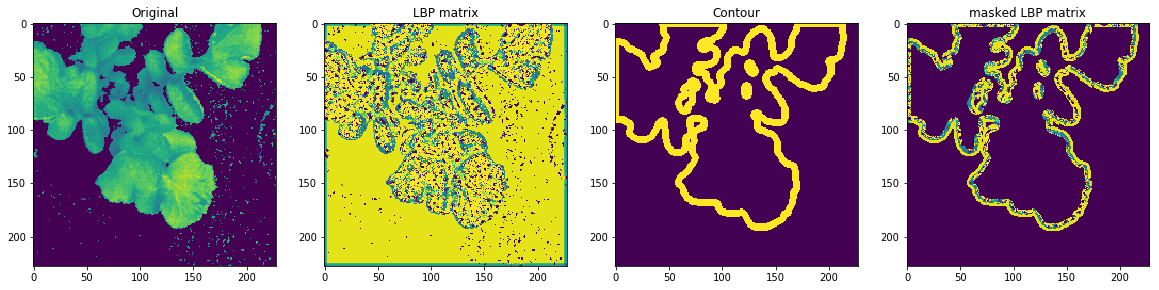

[[255 255 255 255 255 255 255 255 255 255 255 255   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0 255 255 255 255 255 255 255 255   1   1   1
    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
    1   1   1   1   1   1 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0 255 255 255 255 255 255
  255   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 255
  255 255 255 255 255 255   0   0   0   0   0   0   0   0   0   0   0   0
  255 255 255 255 255 255 255   1   1   1   1   1   1   1   1   1   1   1
    1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
    1   1   1   1   1   1   1   1   1   1   1   1 255 255 255 255 255 255
  255   0   0   0   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255 255 255 255 255 255   0   0

In [83]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (20,20)

#orig_img   = cv2.imread('/scratch/git/LBP/data/small_dataset/work/test/can/can4S3-r16-609_b1.bmp', cv2.IMREAD_GRAYSCALE)
plt.subplot(1,4,1)
plt.imshow(a_pp.e.debug_last_image)
plt.title('Original')
plt.subplot(1,4,2)
plt.imshow(a_pp.e.debug_last_lbp_matrix)
plt.title('LBP matrix')
plt.subplot(1,4,3)
plt.imshow(a_pp.e.debug_last_mask)
plt.title('Contour')
plt.subplot(1,4,4)
plt.imshow(a_pp.e.debug_last_masked_lbp_matrix)
plt.title('masked LBP matrix')
plt.show()

print a_pp.e.debug_last_mask[1:20][16:20]

In [50]:
import numpy as np

a= [["a","b","c","d"], ["r",'t'], ['e','y'],['z','g']]
b = [1,2.0,3,40.0]
c = np.delete(a,np.r_[1:2],0)
d = np.copy(a[1:2])
print c
print d

e = np.array(b)
print np.array(b).mean()

b.append([-1])
print "%s" %str(b)

[['a', 'b', 'c', 'd'] ['e', 'y'] ['z', 'g']]
[['r' 't']]
11.5
[1, 2.0, 3, 40.0, [-1]]
